In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from connect4 import *

In [26]:
def state_to_input_representation(state, player):
    X = torch.from_numpy(np.stack((state==1, state==-1, state!=0, np.full_like(state, player))))
    X = X[None, ...].float()
    return X

def output_representation_to_action_prob(O):
    return O


def output_rep_legal_move_mask(legal_moves):
    mask = torch.zeros(7, dtype=bool)
    mask[legal_moves] = True
    return mask

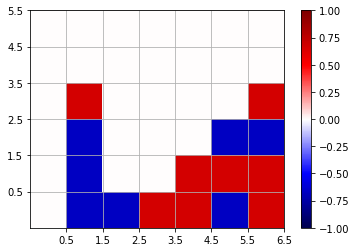

(False, 0)


In [4]:
state = init_state()

player = 1
for i in range(15):
    state = take_action(state, np.random.choice(get_actions(state)), player)
    player = -player

render(state)


plt.show()

print(is_done(state))



In [5]:
get_actions(state)

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
import torch

In [7]:
def get_conv_block(in_channels):
    conv = torch.nn.Conv2d(in_channels, 4, (3, 3), 1, padding=1)
    bn = torch.nn.BatchNorm2d(4)
    relu = torch.nn.ReLU()
    return torch.nn.Sequential(*[conv, bn, relu])

class ResidualBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(4, 4, (3, 3), 1, padding=1)
        self.bn = torch.nn.BatchNorm2d(4)
        self.conv2 = torch.nn.Conv2d(4, 4, (3, 3), 1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(4)
    
    def forward(self, X):
        O = self.conv(X)
        O = self.bn(O)
        O = torch.relu(O)
        O = self.conv2(O)
        O = self.bn2(O)
        O = O + X
        O = torch.relu(O)
        return O
    
class ResidualTower(torch.nn.Module):
    def __init__(self, in_channels, num_res_blocks):
        super().__init__()
        self.conv_block = get_conv_block(in_channels)
        self.res_blocks = torch.nn.Sequential(*[ResidualBlock() for i in range(num_res_blocks)])
    
    def forward(self, X):
        O = self.conv_block(X)
        O = self.res_blocks(O)
        return O

# These are custom modules not in the paper's definitions
def get_policy_head():
    fc1 = torch.nn.Linear(4*6*7, 10)
    fc2 = torch.nn.Linear(10, 10)
    fc3 = torch.nn.Linear(10, 7)
    relu = torch.nn.ReLU()
    sm = torch.nn.Softmax(dim=-1)
    return torch.nn.Sequential(fc1, relu, fc2, relu, fc3, sm)
    
def get_value_head():
    fc1 = torch.nn.Linear(4*6*7, 1)
    fc2 = torch.nn.Linear(1, 1)
    relu = torch.nn.ReLU()
    tahn = torch.nn.Tanh()
    return torch.nn.Sequential(fc1, relu, fc2, tahn)
    

class Connect4Net(torch.nn.Module):
    def __init__(self, num_res_blocks, M=3, T=1, L=1):
        super().__init__()
        self.res_tower = ResidualTower(M*T+L, num_res_blocks)
        
        # [1, 256, 8, 8]
        
        self.policy_head = get_policy_head()
        self.value_head = get_value_head()
        
    
    def forward(self, X):
        # X.shape = (1, 119, 8, 8)
        
        O = self.res_tower(X)
        O = O.view(O.shape[0], -1)
        
        P = self.policy_head(O)
        V = self.value_head(O)
        
        return P, V
    
    
connect4_net = Connect4Net(5)

P,V = connect4_net(torch.randn(1, 4, 6, 7))
print(P.shape)
print(V.shape)

import torchsummary

torchsummary.summary(connect4_net, input_size=(4,6,7))

torch.Size([1, 7])
torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 4, 6, 7]             148
       BatchNorm2d-2              [-1, 4, 6, 7]               8
              ReLU-3              [-1, 4, 6, 7]               0
            Conv2d-4              [-1, 4, 6, 7]             148
       BatchNorm2d-5              [-1, 4, 6, 7]               8
            Conv2d-6              [-1, 4, 6, 7]             148
       BatchNorm2d-7              [-1, 4, 6, 7]               8
     ResidualBlock-8              [-1, 4, 6, 7]               0
            Conv2d-9              [-1, 4, 6, 7]             148
      BatchNorm2d-10              [-1, 4, 6, 7]               8
           Conv2d-11              [-1, 4, 6, 7]             148
      BatchNorm2d-12              [-1, 4, 6, 7]               8
    ResidualBlock-13              [-1, 4, 6, 7]               0
 

In [89]:
class Node:
    def __init__(self, state, player):
        self.state = state
        self.N = 0
        self.W = 0
        self.player = player
        self.actions = None
        self.P = None
        self.children = None
        
    def set_children(self, policy_val_net):
        self.actions = get_actions(self.state)
        
        # TODO mask out illegal moves
#         self.P, self.V = policy_val_net(state_to_input_representation(state, 1)) 
#         self.P = self.P.detach().numpy()[0]
#         self.V = self.V.detach().numpy()[0]
#         
#         self.P = self.P[self.actions]
#         self.P = self.P/self.P.sum()
        self.P = np.ones(7)/7.
        self.V = 0.
        
        mask = output_rep_legal_move_mask(self.actions)
        self.P[~mask] = 0
        self.P = self.P/self.P.sum()
        
        self.children = [Node(take_action(self.state, action, self.player), -self.player) for action in self.actions]
    

def MTCS(state, root, num_sim, player, temperature, policy_val_net):
    if root is None:
        root = Node(state, player)
    
    for sim_idx in range(num_sim):
        MTCS_one_sim(root, player, 6*7, policy_val_net)
        
        
    visit_counts = np.array([child.N for child in root.children])
    visit_counts_temp = visit_counts**(1/temperature)
    
#     print(visit_counts, visit_counts.sum())
    mtcs_p = np.zeros(7)
    mtcs_p[root.actions] = visit_counts_temp/visit_counts_temp.sum()
    
    return root, mtcs_p

def pick_child(node):
    c_upct = 1.
    childN = np.array([child.N for child in node.children])
    childW = np.array([child.W for child in node.children])
    U = c_upct * node.P[node.actions] * np.sqrt(childN.sum())/(1+childN)
    # Q = np.where(childN==0, childN, childW/childN)
    Q = childN
    Q[childN!=0] = childW[childN!=0]/childN[childN!=0]
    
#     action_idx = (Q+U).argmax() # deterministic
    action_idx = np.random.choice(np.arange(len(Q)), p=torch.from_numpy(Q+U).softmax(dim=0).numpy()) # stochastic
#     print(Q+U, Q, U)
#     print(action_idx)
    return node.children[action_idx]

def MTCS_one_sim(node, player, depth, policy_val_net):
#     print('sim iteration')
    done, winner = is_done(node.state)
    
    if not done and node.children is None:
        node.set_children(policy_val_net)
        
    if done:
#         render(node.state, mode='txt')
#         print()
        # if terminal state, or no actions left (terminal)
        node.N, node.W = node.N+1, node.W + winner
        return winner # return absolute winner
    if depth==0:
        # if depth limit reached
        val = node.V[0]
        val_absolute = val if player==1 else -val # return absolute evaluation
        node.N, node.W = node.N+1, node.W + val_absolute
        return val_absolute
    
        
        
    child_node = pick_child(node)
    v = MTCS_one_sim(child_node, -player, depth-1, policy_val_net)
    node.N, node.W = node.N+1, node.W + v
    return v


In [95]:
# training

def epoch_net(connect4_net):
    state = init_state()
    player = 1
    done = False
    childnode = None
#     render(state, mode='txt')

    data = []
    
    while not done:
        actions = get_actions(state)
        root, mtcs_p = MTCS(state, childnode, 10, player, temperature=1, policy_val_net=connect4_net)
        
#         print(actions)
#         print(mtcs_p)
        action = np.random.choice(np.arange(7), p=mtcs_p)
        action_idx = np.where(actions==action)[0][0]
#         print(action)
        
        childnode = root.children[action_idx]
#         print(player, action)
        
        data.append([state, mtcs_p, player, player])

        state = take_action(state, action, player)

        player = -player
        done, winner = is_done(state)

#         render(state, mode='txt')
#         print()
#         plt.show()
#         break
    
    X = []
    Y_true_p = []
    Y_true_v = []
    for d in data:
        d[2] = d[2]*winner
        
        state, mtcs_p, outcome, player = d
        rep = state_to_input_representation(state, player)
        X.append(rep)
        Y_true_p.append(torch.from_numpy(mtcs_p).float())
        Y_true_v.append(torch.tensor(outcome).float())
        
    X = torch.cat(X)
    Y_true_p = torch.stack(Y_true_p)
    Y_true_v = torch.stack(Y_true_v)
    print(X.shape)
    print(Y_true_p.shape)
    print(Y_true_v.shape)
    
#     render(state, mode='txt')
#     return winner, state
epoch_net(connect4_net)


torch.Size([16, 4, 6, 7])
torch.Size([16, 7])
torch.Size([16])


In [77]:
# %%prun
MTCS(state, 200, 1, 1, connect4_net)

TypeError: MTCS() missing 1 required positional argument: 'policy_val_net'

In [12]:
def connect4_net_player(state, actions, connect4_net, deterministic=False):
    P, V = connect4_net(state_to_input_representation(state, player))
    P = P[0, actions].detach().numpy()
    P = P/P.sum()
    
    if deterministic:
        action = actions[P.argmax()] # deterministic 
    else:
        action = np.random.choice(actions, p=P) # stochastic
    return action

def random_player(state, actions):
    return np.random.choice(actions)

def game_p1_vs_p2(p1, p2):
    state = init_state()
    player = 1
    done = False
#     render(state, mode='txt')
    while not done:
        actions = get_actions(state)

        if player==1:
            action = p1(state, actions)
        else:
            action = p2(state, actions)
        
#         print(player, action)
        state = take_action(state, action, player)

        player = -player
        done, winner = is_done(state)

#         render(state, mode='txt')
#         print()
#         plt.show()

#     render(state, mode='txt')
    return winner, state
    

from functools import partial
p_net = partial(connect4_net_player, connect4_net=connect4_net, deterministic=False)
p_rand = random_player


def games_p1_vs_p2(p1, p2, num_games=100):
    p1win, p2win, draw = 0,0,0
    for game_idx in range(num_games):
        p1idx = np.random.choice([-1,1])
        winner, state = game_p1_vs_p2(p1, p2) if p1idx==1 else game_p1_vs_p2(p2, p1)
#         print(winner, p1idx)
        if winner==p1idx:
            p1win += 1
        elif winner==-p1idx:
            p2win += 1
        else:
            draw += 1
    print(p1win, p2win, draw)
    return p1win/num_games, p2win/num_games, draw/num_games


games_p1_vs_p2(p_net, p_rand, 50)



23 27 0


(0.46, 0.54, 0.0)

In [19]:
a = np.random.randint(10, 100, size=(7))


a/a.sum()

array([0.13380282, 0.22535211, 0.14319249, 0.03755869, 0.22065728,
       0.02347418, 0.21596244])

In [23]:
temp = 3
(a**(1/temp))/(a**(1/temp)).sum()

array([0.14745596, 0.17543967, 0.15082754, 0.09654817, 0.17421278,
       0.08254752, 0.17296836])